# **US Accidents Analysis and Visualization**
This notebook focuses on exploring and visualizing the US accidents dataset. The steps include data preprocessing, cleaning, and generating insightful visualizations.


**Team Members**

Buğra Burak Başer, Melike Beria Ayas, Abdullah Salih Öner


## **1. Importing Libraries**
We start by importing necessary libraries for data analysis and visualization.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from pandasql import sqldf
import warnings
import geopandas as gpd
import tensorflow as tf
import plotly.graph_objects as go
from nltk.corpus import stopwords

from sklearn.utils import resample
import torch


# Configure plots for better readability
sns.set_theme(style="darkgrid", palette="muted", font_scale=1.1)
pd.set_option('display.max_columns', None)

# Set device to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [13]:
# CUDA versiyonunu kontrol et
!nvcc --version

# GPU'nun doğru şekilde tanındığını doğrula
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

print("Is GPU available?", tf.test.is_gpu_available())
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
CUDA is available!
GPU Device Name: Tesla P100-PCIE-16GB
Is GPU available? True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [85]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

## **2. Loading the Dataset**
The dataset contains traffic accident records from the United States (2016-2019). We load the data and inspect its structure.


In [15]:
# Path to dataset
data_path = "/kaggle/input/us-accidents/US_Accidents_March23.csv"

# Load dataset
df = pd.read_csv(data_path)

# Display basic information
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns)
df.head()


Dataset Shape: (7728394, 46)
Dataset Columns: Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


## **3. Checking for Missing Data**
We identify columns with missing values and address them appropriately during preprocessing.


In [16]:
# Check missing values
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]  # Only display columns with missing data
print("Columns with Missing Values:\n", missing_data)

Columns with Missing Values:
 End_Lng                  3402762
End_Lat                  3402762
Precipitation(in)        2203586
Wind_Chill(F)            1999019
Wind_Speed(mph)           571233
Visibility(mi)            177098
Wind_Direction            175206
Humidity(%)               174144
Weather_Condition         173459
Temperature(F)            163853
Pressure(in)              140679
Weather_Timestamp         120228
Sunrise_Sunset             23246
Civil_Twilight             23246
Astronomical_Twilight      23246
Nautical_Twilight          23246
Airport_Code               22635
Street                     10869
Timezone                    7808
Zipcode                     1915
City                         253
Description                    5
dtype: int64


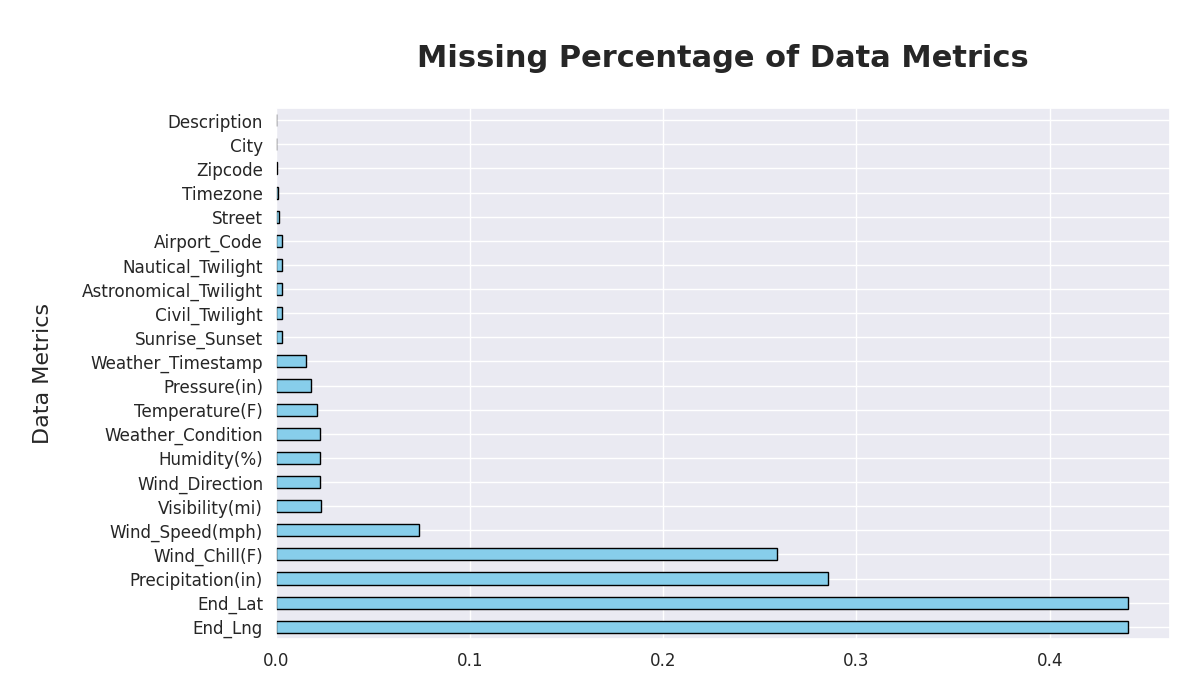

In [17]:
# Visualization for Missing Data
plt.figure(figsize=(12, 7))  
plt.title('\nMissing Percentage of Data Metrics\n', fontsize=22, fontweight='bold') 
plt.ylabel('\nData Metrics\n', fontsize=16)  
plt.xlabel('\nMissing Percentage\n', fontsize=16) 

missing_percentage = df.isna().sum().sort_values(ascending=False) / len(df)
missing_percentage[missing_percentage != 0].plot(kind='barh', color='skyblue', edgecolor='black')

plt.tight_layout()
plt.show()


The dataset contains missing values in several columns, especially **`End_Lat`** and **`End_Lng`**. Those columns will be dropped. Weather-related columns like **`Precipitation(in)`** and **`Wind_Chill(F)`** will be filled with their **median** values. Categorical columns like **`Sunrise_Sunset`**, **`Weather_Condition`** will be filled with the **mode**. Minor missing values in columns like **`Description`** and **`City`** will be fixed by dropping affected rows.

## **4. Handling Missing Values and Transforming Date Time Columns**
### 4.1 Handling Missing Values
- Fill missing numerical values with median value
- Fill missing categorical rows with mode
.
- Drop rows with critical missing data.


In [18]:
# Dropping columns with excessive missing values
df.drop(columns=['End_Lat', 'End_Lng'], inplace=True)

# Filling missing weather-related columns with the median
weather_cols = ['Precipitation(in)', 'Wind_Chill(F)', 'Wind_Speed(mph)', 
                'Visibility(mi)', 'Temperature(F)', 'Pressure(in)', 'Humidity(%)']
for col in weather_cols:
    df[col] = df[col].fillna(df[col].median())  # Direct assignment without inplace=True

# Filling categorical columns with mode
categorical_cols = ['Weather_Condition', 'Wind_Direction', 
                    'Sunrise_Sunset', 'Civil_Twilight', 
                    'Nautical_Twilight', 'Astronomical_Twilight']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # Direct assignment without inplace=True

# Dropping rows with critical missing data (e.g., 'Description', 'City')
df.dropna(subset=['Description', 'City'], inplace=True)

# Verify if missing values are addressed
print("Remaining Missing Values:\n", df.isnull().sum().sum())


Remaining Missing Values:
 163445


In [19]:
remaining_missing = df.isnull().sum()
print(remaining_missing[remaining_missing > 0])


Street                10869
Zipcode                1913
Timezone               7806
Airport_Code          22633
Weather_Timestamp    120224
dtype: int64


Rows with missing `Zipcode` were dropped, and the `Street` column was removed. Missing `Timezone` values were filled with the mode, while `Airport_Code` and `Weather_Timestamp` were dropped for simplicity, resulting in a cleaner dataset.












In [20]:
# Drop rows where Zipcode is missing
df = df[df['Zipcode'].notna()]

# Drop the Street column
df = df.drop(columns=['Street'])

# Fill missing Timezone values with the mode
timezone_mode = df['Timezone'].mode()[0]
df.loc[:, 'Timezone'] = df['Timezone'].fillna(timezone_mode)

# Drop Airport_Code and Weather_Timestamp columns
df = df.drop(columns=['Airport_Code', 'Weather_Timestamp'])

# Verify the remaining missing values
print("Remaining Missing Values After Cleanup:\n", df.isnull().sum().sum())

Remaining Missing Values After Cleanup:
 0


### 4.2 Transforming Date-Time Columns
Extract useful features such as `Year`, `Month`, `Day`, and `Hour` from the `Start_Time` column for analysis.


In [21]:
# Convert Start_Time and End_Time to datetime, handling invalid formats
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Check for rows with NaT (invalid dates)
invalid_dates = df[df['Start_Time'].isna() | df['End_Time'].isna()]
print(f"Number of invalid Start_Time or End_Time entries: {len(invalid_dates)}")

# Drop rows with invalid Start_Time or End_Time
df = df.dropna(subset=['Start_Time', 'End_Time'])

# Extract features from Start_Time
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour

# Optional: Verify the newly created columns
print(df[['Start_Time', 'Year', 'Month', 'Day', 'Hour']].head())


Number of invalid Start_Time or End_Time entries: 742903
           Start_Time  Year  Month  Day  Hour
0 2016-02-08 05:46:00  2016      2    8     5
1 2016-02-08 06:07:59  2016      2    8     6
2 2016-02-08 06:49:27  2016      2    8     6
3 2016-02-08 07:23:34  2016      2    8     7
4 2016-02-08 07:39:07  2016      2    8     7


## **5. Exploratory Data Analysis**### 5.1  Accidents by Year
Visualizing the number of accidents recorded in each year.


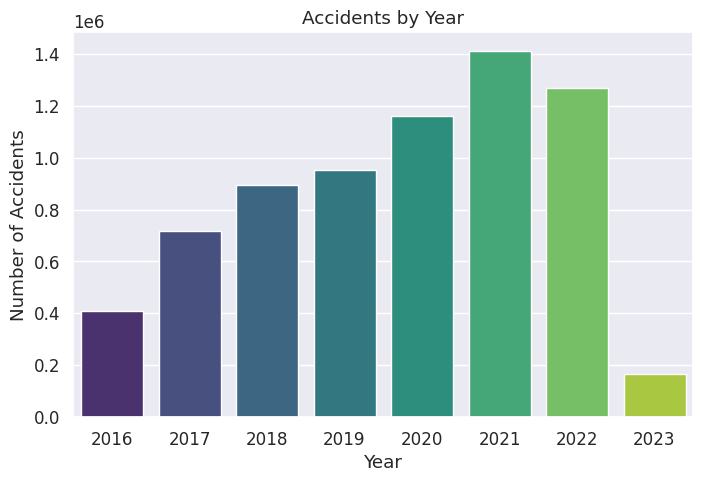

In [22]:
# Plot accidents by year
plt.figure(figsize=(8, 5))
sns.countplot(x='Year', data=df, palette='viridis')
plt.title("Accidents by Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.show()


The yearly distribution highlights a general increase in accidents over time, but this trend may primarily reflect reporting patterns or data collection improvements rather than actual changes in accident frequency. Therefore, **year-based trends might not provide significant insights** for understanding accident causes or severity.

### 5.2 Hourly Accident Distributionon
Analyzing at what time of the day most accidents occur.


In [23]:
# Check if there are any infinite, NaN or non-numeric values in the Hour column

print("Infinite values in 'Hour':", np.isinf(df['Hour']).sum())
print("NaN values in 'Hour':", df['Hour'].isna().sum())
print("Non-numeric values in 'Hour':", df['Hour'].apply(lambda x: not isinstance(x, (int, float))).sum())


Infinite values in 'Hour': 0
NaN values in 'Hour': 0
Non-numeric values in 'Hour': 0



Since the `Hour` column has **no infinite, NaN,** or **non-numeric** values, the data is clean.

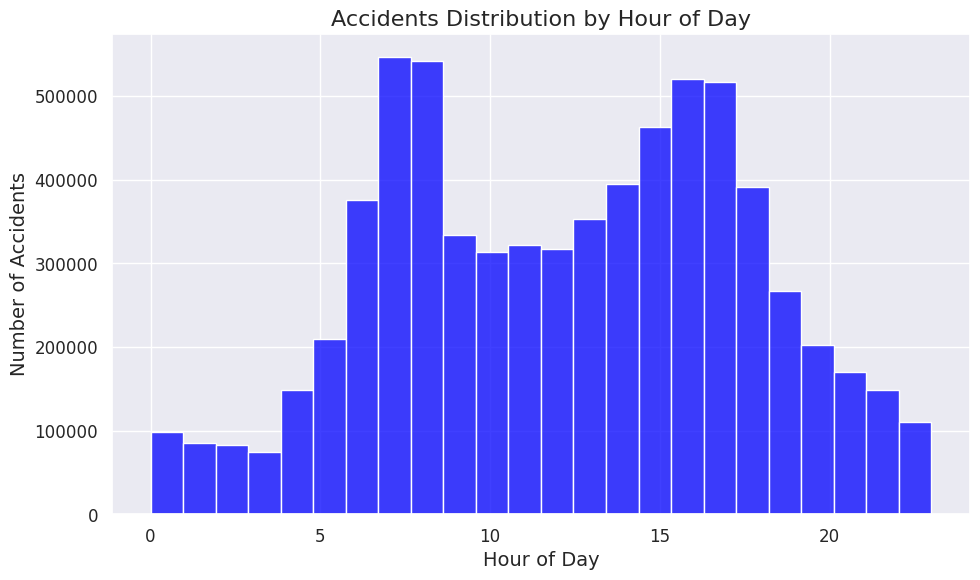

In [24]:


# As we know that the data is clean, we can ignore the errors that possibly occured because of the version difference.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Plot the hourly accident distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Hour'], bins=24, kde=False, color='blue')
    plt.title("Accidents Distribution by Hour of Day", fontsize=16)
    plt.xlabel("Hour of Day", fontsize=14)
    plt.ylabel("Number of Accidents", fontsize=14)
    plt.tight_layout()
    plt.show()


This histogram reveals a clear pattern in the hourly distribution of accidents. Peaks occur during **morning rush hours (6-9 AM)** and **evening rush hours (3-6 PM)**, likely due to increased traffic during commuting times. The distribution highlights the importance of targeted safety measures during these periods.







### **5.3 Number of Cases by City**
This visualization shows the top 20 cities with the highest number of traffic accidents. It provides insights into which urban areas are most affected by accidents, helping identify potential hotspots for traffic safety improvements.


In [25]:
# Check how many unique cities are in the dataset
unique_cities = df['City'].nunique()
unique_cities

13557

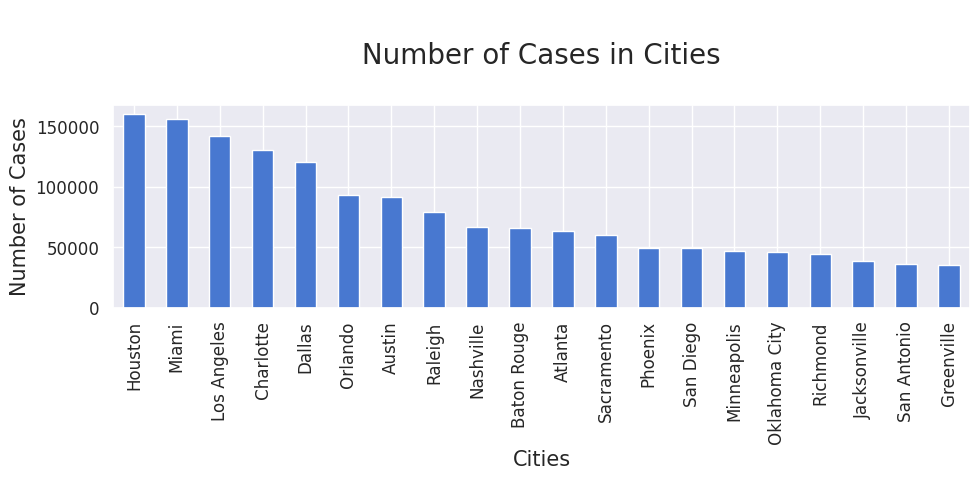

In [26]:
# Top 20 cities with the highest number of accidents
cities_accidents = df.City.value_counts()

ax = cities_accidents[:20].plot(kind='bar', title='\n Number of Cases in Cities \n', figsize=(10, 5))
ax.title.set_size(20) 
ax.set_xlabel("Cities", fontdict={'fontsize': 15}) 
ax.set_ylabel("Number of Cases", fontdict={'fontsize': 15}) 
plt.tight_layout()
plt.show()


This bar chart highlights the top cities with the highest number of accidents, with **Houston, Miami, and Los Angeles** leading. These cities may experience high traffic volumes or risk factors contributing to accidents, making them key areas for traffic safety interventions.


### **5.4 Distribution of Accidents by Temperature**
This visualization illustrates the distribution of accidents based on temperature (`Temperature(F)`). The density plot provides insights into how temperature variations might correlate with accident occurrences.


In [27]:
# Check if there are any infinite, NaN, or non-numeric values in the 'Temperature(F)' column

print("Infinite values in 'Temperature(F)':", np.isinf(df['Temperature(F)']).sum())
print("NaN values in 'Temperature(F)':", df['Temperature(F)'].isna().sum())
print("Non-numeric values in 'Temperature(F)':", df['Temperature(F)'].apply(lambda x: not isinstance(x, (int, float))).sum())


Infinite values in 'Temperature(F)': 0
NaN values in 'Temperature(F)': 0
Non-numeric values in 'Temperature(F)': 0


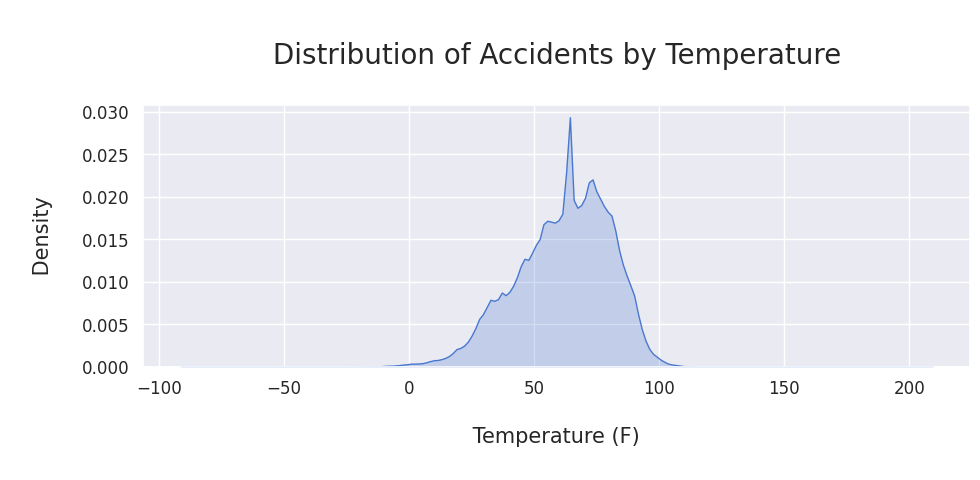

In [28]:
# As we know that the data is clean, we can ignore the errors that possibly occured because of the version difference.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Filter valid data for Temperature(F)
    plt.figure(figsize=(10, 5))
    plt.title('\n Distribution of Accidents by Temperature \n', size=20)
    plt.ylabel('\n Density \n', fontsize=15)
    plt.xlabel('\n Temperature (F) \n', fontsize=15)
    sns.kdeplot(data=df['Temperature(F)'], fill=True)
    plt.tight_layout()
    plt.show()


The distribution shows that most accidents occur in moderate temperatures, primarily between **30°F and 70°F**, with a peak around **50°F**. This trend suggests that moderate weather conditions, which are more common in populated areas, see the highest traffic activity. Accidents are less frequent in extreme temperatures, likely due to reduced travel or increased caution during harsh weather conditions.

### **5.5 Distribution of Accidents by Visibility**
This visualization highlights the distribution of accidents based on visibility conditions (`Visibility(mi)`). The density plot provides insights into how visibility levels might influence accident occurrences.


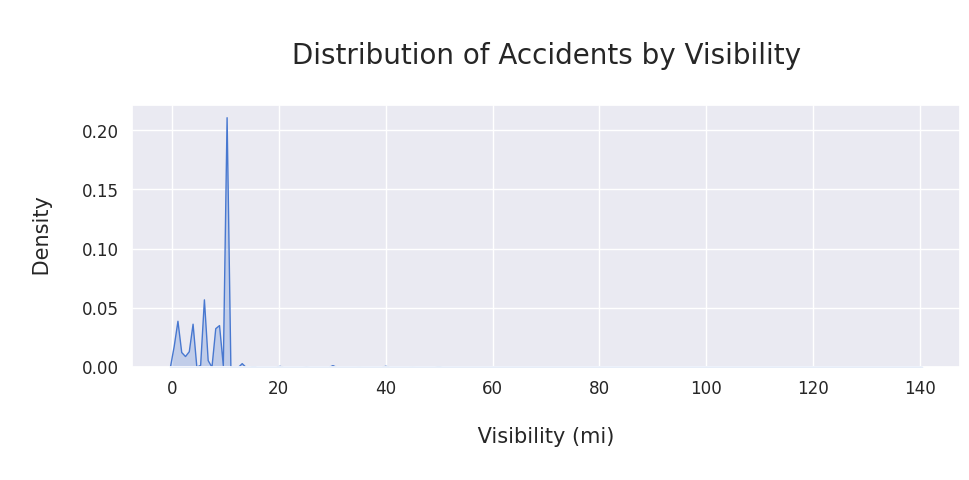

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plot: Distribution of Accidents by Visibility
    plt.figure(figsize=(10, 5))
    plt.title('\n Distribution of Accidents by Visibility \n', size=20)
    plt.ylabel('\n Density \n', fontsize=15)
    plt.xlabel('\n Visibility (mi) \n', fontsize=15)
    sns.kdeplot(data=df["Visibility(mi)"], fill=True)  # Replace shade=True with fill=True
    plt.tight_layout()
    plt.show()

The distribution indicates that **most accidents occur under low visibility conditions**, particularly between 0-10 miles, likely due to weather-related hazards like fog, rain, or snow. Accidents decrease significantly as visibility improves beyond 10 miles. The presence of outliers with extremely high visibility values suggests potential data anomalies or rare cases, which may warrant further investigation.

### **5.6 Distribution of Accidents by Wind Speed**
This visualization shows the distribution of accidents based on wind speed (`Wind_Speed(mph)`). The density plot offers insights into how variations in wind speed correlate with accident occurrences.


In [30]:
# Check if there are any infinite, NaN, or non-numeric values in the 'Wind_Speed(mph)' column

print("Infinite values in 'Wind_Speed(mph)':", np.isinf(df['Wind_Speed(mph)']).sum())
print("NaN values in 'Wind_Speed(mph)':", df['Wind_Speed(mph)'].isna().sum())
print("Non-numeric values in 'Wind_Speed(mph)':", df['Wind_Speed(mph)'].apply(lambda x: not isinstance(x, (int, float))).sum())


Infinite values in 'Wind_Speed(mph)': 0
NaN values in 'Wind_Speed(mph)': 0
Non-numeric values in 'Wind_Speed(mph)': 0


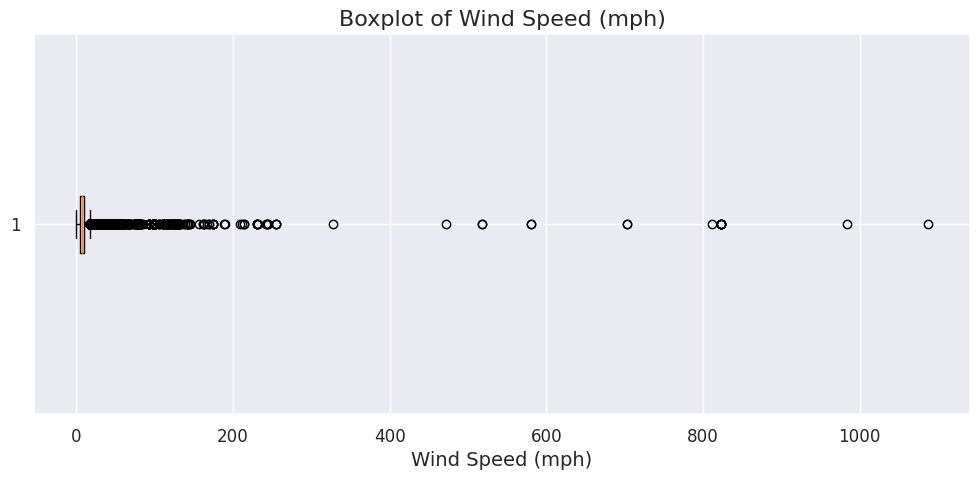

In [31]:
# Plot a boxplot to check for outliers in 'Wind_Speed(mph)'
plt.figure(figsize=(10, 5))
plt.title("Boxplot of Wind Speed (mph)", fontsize=16)
plt.xlabel("Wind Speed (mph)", fontsize=14)
plt.boxplot(df['Wind_Speed(mph)'], vert=False) 
plt.tight_layout()
plt.show()

In [32]:
# Calculate the IQR and thresholds for outliers in 'Wind_Speed(mph)'
Q1 = df['Wind_Speed(mph)'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['Wind_Speed(mph)'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile Range

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


Lower Bound: -2.5
Upper Bound: 17.5


Lower Bound for a wind speed cannot be negative thats why we set 0.

In [33]:
# Correct the lower bound to 0 (minimum valid wind speed)
lower_bound = 0

In [34]:
# Filter the dataset based on the corrected bounds
df_cleaned = df[(df['Wind_Speed(mph)'] >= lower_bound) & (df['Wind_Speed(mph)'] <= upper_bound)]

# Verify the updated column
print("Cleaned 'Wind_Speed(mph)' statistics:")
print(df_cleaned['Wind_Speed(mph)'].describe())

Cleaned 'Wind_Speed(mph)' statistics:
count    6.723566e+06
mean     7.105179e+00
std      4.250687e+00
min      0.000000e+00
25%      4.600000e+00
50%      7.000000e+00
75%      9.200000e+00
max      1.730000e+01
Name: Wind_Speed(mph), dtype: float64


In [35]:
# Calculate the number of rows dropped
rows_dropped = len(df) - len(df_cleaned)
print("Number of rows dropped:", rows_dropped)

Number of rows dropped: 259754


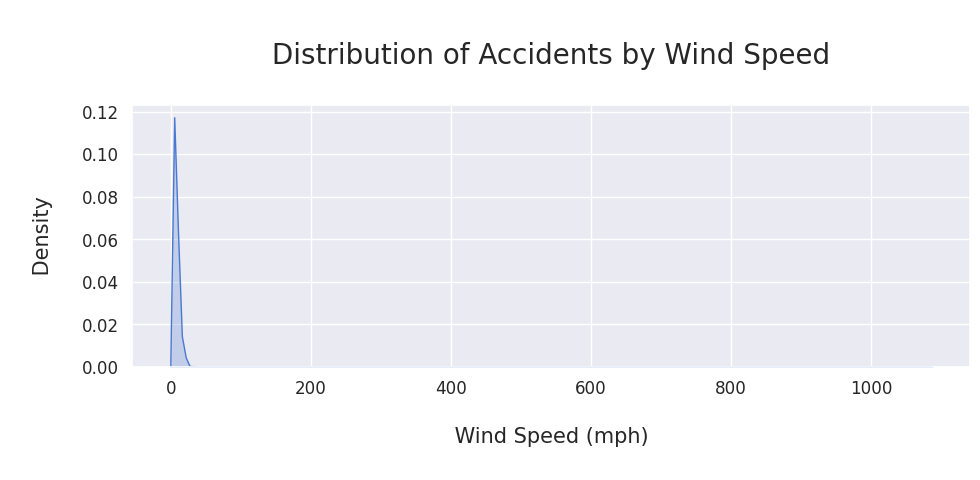

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plot: Distribution of Accidents by Wind Speed
    plt.figure(figsize=(10, 5))
    plt.title('\n Distribution of Accidents by Wind Speed \n', size=20)
    plt.ylabel('\n Density \n', fontsize=15)
    plt.xlabel('\n Wind Speed (mph) \n', fontsize=15)
    sns.kdeplot(data=df["Wind_Speed(mph)"], fill=True)  # Replace shade=True with fill=True
    plt.tight_layout()
    plt.show()

The distribution shows that most accidents occur under low wind speed conditions, primarily below 20 mph, with a sharp peak near zero wind speed. This suggests that wind speed has minimal direct impact on the majority of accidents. However, the presence of outliers with extreme wind speeds (above 200 mph) may indicate erroneous data entries or rare, severe weather conditions like hurricanes or tornadoes. Cleaning the data to focus on realistic wind speeds could improve the clarity of this analysis.


### **5.7 Distribution of Cases by Severity**
This pie chart visualizes the proportion of traffic accidents across different severity levels (`Severity`). It helps to understand how accidents are distributed by their impact.


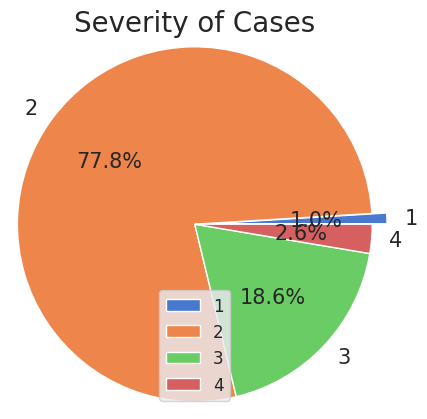

In [37]:
# Count accidents grouped by severity using pandas
severity_pie = df.groupby("Severity").size()

# Labels for severity levels
mylabels = severity_pie.index.astype(str)

# Plot the pie chart
plt.title("Severity of Cases", fontsize=20)
plt.pie(
    severity_pie,
    labels=mylabels,
    autopct='%1.1f%%',
    textprops={'fontsize': 15},
    radius=1.2,
    explode=(0.1, 0, 0, 0)  # Slightly emphasize the first segment
)
plt.legend(mylabels, loc="best")
plt.show()


The pie chart reveals that the majority of traffic accidents (77.8%) fall under severity level **2**, indicating moderately severe incidents. Severity level **3** accounts for 18.6% of accidents, representing more serious cases. Levels **1** and **4** together contribute to less than 4% of cases, highlighting that extremely minor or severe accidents are relatively rare. This distribution suggests a focus on mitigating moderately severe accidents could yield significant safety improvements.







### **5.8 Temperature Distribution by Severity**

This visualization shows the distribution of reported temperatures (`Temperature(F)`) during accidents, grouped by severity levels. It highlights how different severities might correlate with temperature conditions.


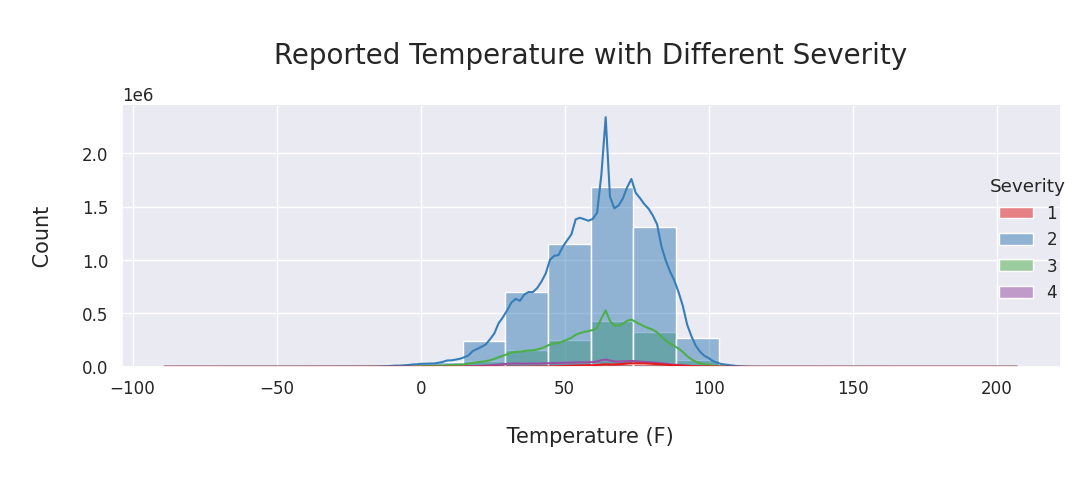

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Plot: Temperature Distribution by Severity
    sns.displot(
        df, 
        x="Temperature(F)", 
        hue="Severity", 
        palette="Set1", 
        height=5, 
        aspect=2, 
        bins=20, 
        kde=True
    )

    # Add title and labels
    plt.title('\n Reported Temperature with Different Severity \n', size=20)
    plt.ylabel('\n Count \n', fontsize=15)
    plt.xlabel('\n Temperature (F) \n', fontsize=15)

    # Display the plot
    plt.tight_layout()
    plt.show()

This visualization highlights the distribution of accidents across temperature ranges, grouped by severity levels. The majority of accidents occur at moderate temperatures between **30°F and 70°F**, with severity level **2** dominating, as expected from previous analyses. Severity levels **3** and **4** are more evenly distributed within this range, but they remain relatively infrequent compared to level **2**. The presence of very low and high temperatures (e.g., below 0°F or above 100°F) is rare, likely due to less frequent driving in extreme weather conditions. This distribution suggests that temperature alone may not strongly influence the severity of accidents.

### **5.9 Wind Direction Impact on Severity**


This bar chart visualizes the proportion of accidents by wind direction, grouped by severity levels. It highlights whether wind direction has a significant influence on accident severity.


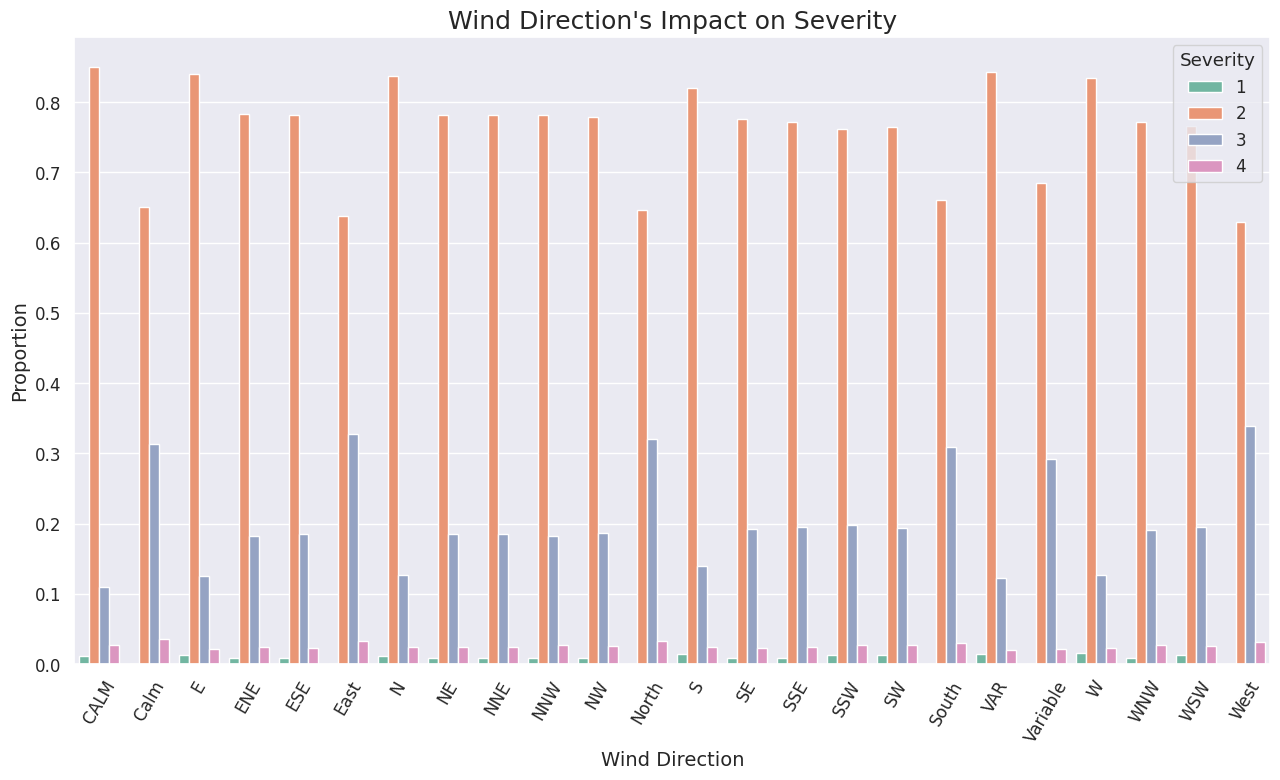

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a proportional dataset for Wind Direction grouped by Severity
wind_data = df.groupby(['Wind_Direction', 'Severity']).size().reset_index(name='Count')
wind_data['Proportion'] = wind_data.groupby('Wind_Direction')['Count'].transform(lambda x: x / x.sum())

# Plot the proportional bar chart
plt.figure(figsize=(13, 8))
sns.barplot(
    data=wind_data,
    x='Wind_Direction',
    y='Proportion',
    hue='Severity',
    palette='Set2'
)

# Customize the plot
plt.xlabel("Wind Direction", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title("Wind Direction's Impact on Severity", fontsize=18)
plt.xticks(rotation=60)  # Rotate x-axis labels
plt.tight_layout()

# Display the plot
plt.show()


The chart shows the proportion of accident severity levels for various wind directions. Severity level **2** consistently dominates across all wind directions, while other severity levels show relatively minor variations. There appears to be no significant correlation between wind direction and accident severity, as the distribution remains largely uniform regardless of the wind direction. This suggests that wind direction may not be a strong factor influencing accident severity.

### **5.10 Number of Accidents per State**


In [40]:
state_counts = df["State"].value_counts()
fig = go.Figure(data=go.Choropleth(locations=state_counts.index, z=state_counts.values.astype(float), locationmode="USA-states", colorscale="turbo"))
fig.update_layout(title_text="Number of US Accidents for each State", geo_scope="usa")
fig.show()

### **5.11 Most Frequent Road Features**


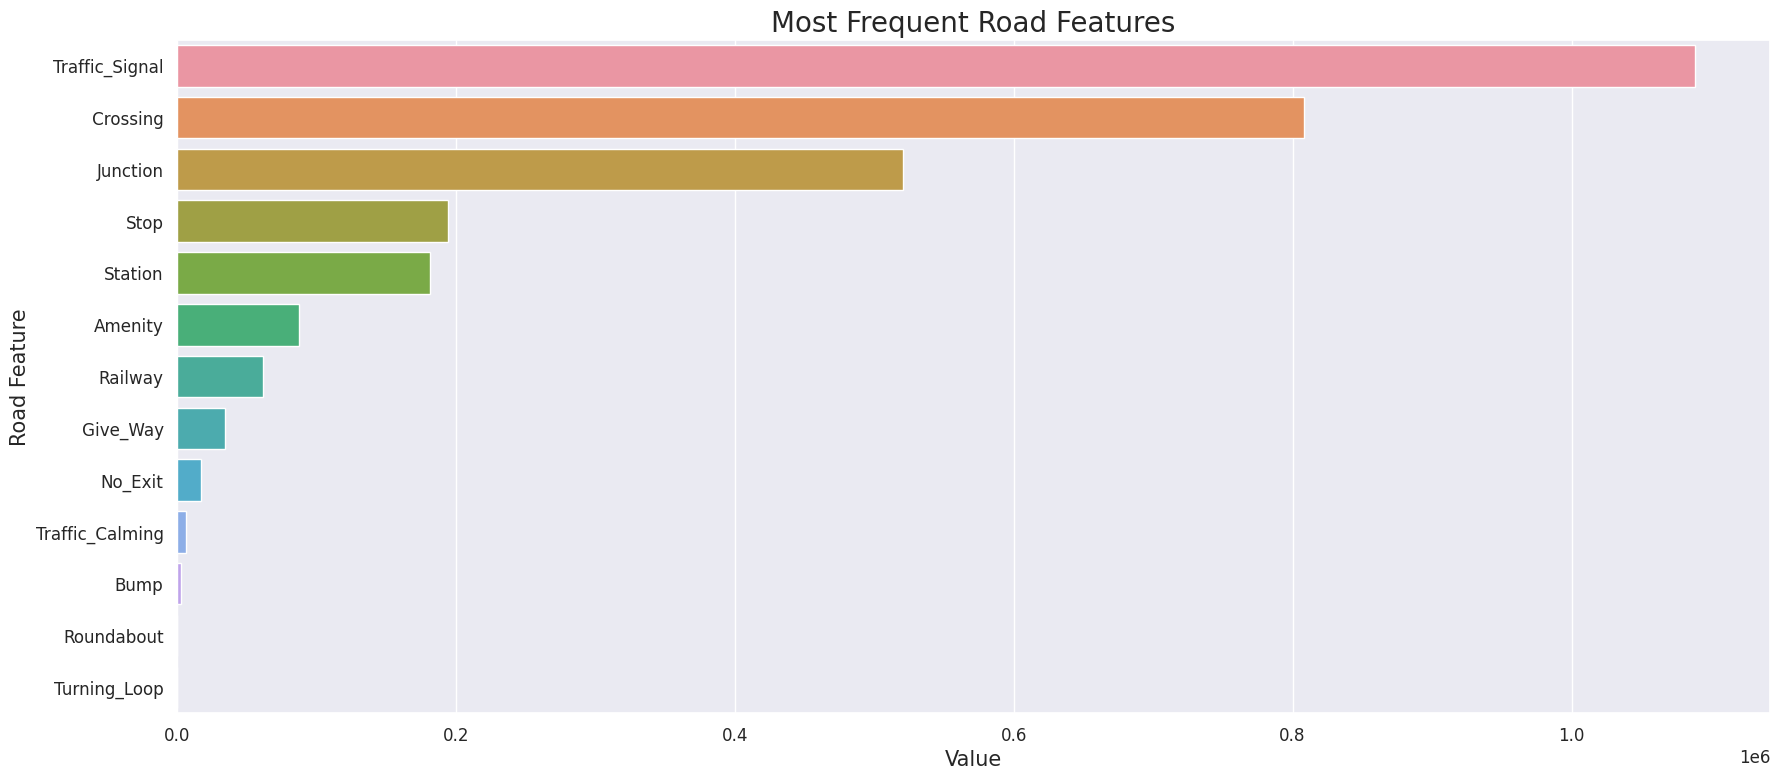

In [41]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", 
                 "No_Exit", "Railway", "Roundabout", "Station", "Stop", 
                 "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]

# Sum and sort road feature data
data = df[road_features].sum().sort_values(ascending=False)

# Plot the barplot
plt.figure(figsize=(18, 8))
plt.title("Most Frequent Road Features", fontsize=20)
sns.barplot(x=data.values, y=data.index, orient="h")  # Pass x and y explicitly
plt.xlabel("Value", fontsize=15)
plt.ylabel("Road Feature", fontsize=15)
plt.tight_layout()
plt.show()

## **6. Data Preprocessing**
Before exploring feature relationships, it's crucial to prepare the data for analysis. This includes ensuring there are no missing values, encoding categorical variables, and standardizing numerical features if necessary.



In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6983320 entries, 0 to 7728393
Data columns (total 45 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   Distance(mi)           float64       
 8   Description            object        
 9   City                   object        
 10  County                 object        
 11  State                  object        
 12  Zipcode                object        
 13  Country                object        
 14  Timezone               object        
 15  Temperature(F)         float64       
 16  Wind_Chill(F)          float64       
 17  Humidity(%)            float64       
 18  Pressure(in)           floa

In [142]:
df_sample = df
df_sample.head()


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,City,County,State,Zipcode,Country,Timezone,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,Dayton,Montgomery,OH,45424,US,US/Eastern,36.9,62.0,91.0,29.68,10.0,Calm,7.0,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2016,2,8,5
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,37.9,62.0,100.0,29.65,10.0,Calm,7.0,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,2016,2,8,6
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,Williamsburg,Clermont,OH,45176,US,US/Eastern,36.0,33.3,100.0,29.67,10.0,SW,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,2016,2,8,6
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,Dayton,Montgomery,OH,45417,US,US/Eastern,35.1,31.0,96.0,29.64,9.0,SW,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,2016,2,8,7
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Dayton,Montgomery,OH,45459,US,US/Eastern,36.0,33.3,89.0,29.65,6.0,SW,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2016,2,8,7


### **6.1 Check Correlation Between Features**

Correlation analysis helps us understand relationships between numerical features in the dataset. This can be particularly useful for feature selection and multicollinearity checks.


In [143]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6983320 entries, 0 to 7728393
Data columns (total 45 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   Distance(mi)           float64       
 8   Description            object        
 9   City                   object        
 10  County                 object        
 11  State                  object        
 12  Zipcode                object        
 13  Country                object        
 14  Timezone               object        
 15  Temperature(F)         float64       
 16  Wind_Chill(F)          float64       
 17  Humidity(%)            float64       
 18  Pressure(in)           floa

This step generates a **correlation matrix** to analyze relationships between **numerical and boolean** features, helping identify feature dependencies and potential multicollinearity. The heatmap visually highlights these correlations, guiding feature selection for better model performance.

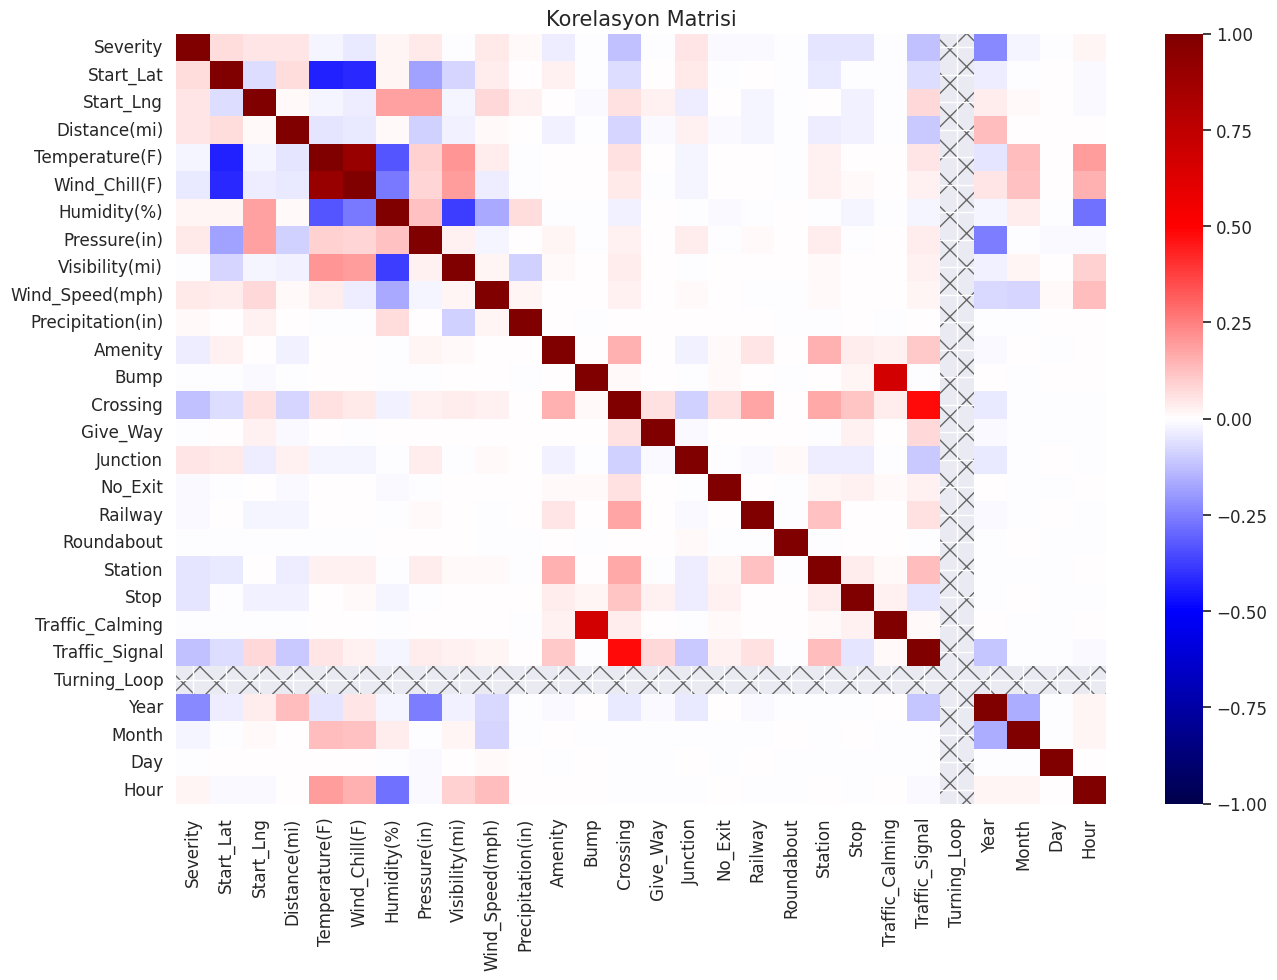

In [144]:
# Select only numeric columns for correlation computation
numeric_cols = df_sample.select_dtypes(include=['float64', 'int64', 'int32', 'bool']).columns
df_sample_numeric = df_sample[numeric_cols]

# Compute the correlation matrix
corr_matrix = df_sample_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))  # Görsel boyutu
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic", annot=False)  # Korelasyon haritası
plt.gca().patch.set(hatch="X", edgecolor="#666")  # Desen ekleme
plt.title("Korelasyon Matrisi", fontsize=15)
plt.show()

**Severity** has weak correlations with most features, suggesting no strong linear relationship.

**Traffic Signal and Traffic Calming.** These two features show a small positive correlation, likely due to their connection in urban infrastructure.

Similarly, **Wind Chill** is directly proportional to **Temperature(F)**, so we can drop one of them as they provide overlapping information.

We also note a slight positive correlation between the presence of a **Traffic Signal** and the **Severity** of an accident, suggesting that traffic signals may influence accident dynamics or severity, possibly aiding traffic flow during incidents.

### **6.2 Feature Selection**


In this section, we perform feature selection to retain only the most meaningful features for our machine learning models.

The features to be removed are identified based on correlation analysis, redundancy, or lack of relevance to the target task.

In [145]:
# List of features to drop based on analysis
columns_to_drop = [
    'Wind_Chill(F)',       # Redundant with Temperature(F)
    'ID', 'Source', 'Year', 'City',        # Irrelevant for severity prediction
    'Start_Time',          # Decomposed into Year, Month, Day, Hour
    'End_Time',            # Cannot be known in advance
    'Description',         # Simplified by focusing on City
    'County', 'State', 'Zipcode', 'Country',  # Redundant with City
    'Timezone', 'Wind_Direction',  # Not relevant to the task
    'Turning_Loop',        # Always False
    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'  # Redundant features
]

# Drop the selected columns
df_sample = df_sample.drop(columns=columns_to_drop, axis=1)

# Display the remaining features
print("Remaining features after feature selection:")
print(df_sample.columns)

Remaining features after feature selection:
Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Month', 'Day', 'Hour'],
      dtype='object')


In [146]:
df_sample.head()


,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Month,Day,Hour
0,3,39.865147,-84.058723,0.01,36.9,91.0,29.68,10.0,7.0,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,2,8,5
1,2,39.928059,-82.831184,0.01,37.9,100.0,29.65,10.0,7.0,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,2,8,6
2,2,39.063148,-84.032608,0.01,36.0,100.0,29.67,10.0,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,2,8,6
3,3,39.747753,-84.205582,0.01,35.1,96.0,29.64,9.0,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,2,8,7
4,2,39.627781,-84.188354,0.01,36.0,89.0,29.65,6.0,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,2,8,7


This selection ensures the dataset is well-prepared for machine learning tasks without redundant or irrelevant columns.

In [147]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6983320 entries, 0 to 7728393
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Temperature(F)     float64
 5   Humidity(%)        float64
 6   Pressure(in)       float64
 7   Visibility(mi)     float64
 8   Wind_Speed(mph)    float64
 9   Precipitation(in)  float64
 10  Weather_Condition  object 
 11  Amenity            bool   
 12  Bump               bool   
 13  Crossing           bool   
 14  Give_Way           bool   
 15  Junction           bool   
 16  No_Exit            bool   
 17  Railway            bool   
 18  Roundabout         bool   
 19  Station            bool   
 20  Stop               bool   
 21  Traffic_Calming    bool   
 22  Traffic_Signal     bool   
 23  Month              int32  
 24  Day                int32  
 25  Hour               int3

### **6.2 Drop Duplicates**



In [148]:
# Check for duplicate rows
print("Checking for duplicate rows...")
duplicates = df_sample.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicate rows if any
if duplicates > 0:
    df_sample = df_sample.drop_duplicates()
    print(f"Duplicate rows dropped. Remaining rows: {len(X)}")
else:
    print("No duplicate rows found.")

Checking for duplicate rows...
Number of duplicate rows: 354466
Duplicate rows dropped. Remaining rows: 252120


In [149]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6628854 entries, 0 to 7728393
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Temperature(F)     float64
 5   Humidity(%)        float64
 6   Pressure(in)       float64
 7   Visibility(mi)     float64
 8   Wind_Speed(mph)    float64
 9   Precipitation(in)  float64
 10  Weather_Condition  object 
 11  Amenity            bool   
 12  Bump               bool   
 13  Crossing           bool   
 14  Give_Way           bool   
 15  Junction           bool   
 16  No_Exit            bool   
 17  Railway            bool   
 18  Roundabout         bool   
 19  Station            bool   
 20  Stop               bool   
 21  Traffic_Calming    bool   
 22  Traffic_Signal     bool   
 23  Month              int32  
 24  Day                int32  
 25  Hour               int3

### **6.3 Handle Wrong and Missing Values**



There is no missing values... It fixed before data analyse.

In [150]:
# Handle missing values
print("Handling missing values...")
missing_values = df_sample.isnull().sum()
print("Missing values per column:")
print(missing_values)


Handling missing values...
Missing values per column:
Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Month                0
Day                  0
Hour                 0
dtype: int64


In [154]:
# Drop rows with missing or invalid values for specific columns
if 'Side' in df_sample.columns:
    print("Cleaning 'Side' column...")
    df_sample = df_sample[df_sample['Side'] != " "]

if 'Pressure(in)' in df_sample.columns:
    df_sample= df_sample[df_sample['Pressure(in)'] > 0]  # Drop rows with zero Pressure
    
if 'Visibility(mi)' in df_sample.columns:
    df_sample = df_sample[df_sample['Visibility(mi)'] > 0]  # Drop rows with zero Visibility

In [153]:
# Consolidate Weather_Condition values
if 'Weather_Condition' in df_sample.columns:
    print("Consolidating 'Weather_Condition' categories...")
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Thunder|T-Storm", na=False), 'Weather_Condition'] = "Thunderstorm"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Snow|Sleet|Wintry", na=False), 'Weather_Condition'] = "Snow"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Rain|Drizzle|Shower", na=False), 'Weather_Condition'] = "Rain"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Wind|Squalls", na=False), 'Weather_Condition'] = "Windy"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Hail|Pellets", na=False), 'Weather_Condition'] = "Hail"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Fair", na=False), 'Weather_Condition'] = "Clear"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Cloud|Overcast", na=False), 'Weather_Condition'] = "Cloudy"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Mist|Haze|Fog", na=False), 'Weather_Condition'] = "Fog"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Sand|Dust", na=False), 'Weather_Condition'] = "Sand"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("Smoke|Volcanic Ash", na=False), 'Weather_Condition'] = "Smoke"
    df_sample.loc[df_sample['Weather_Condition'].str.contains("N/A Precipitation", na=False), 'Weather_Condition'] = np.nan

print(df_sample["Weather_Condition"].unique())

Consolidating 'Weather_Condition' categories...
['Rain' 'Cloudy' 'Snow' 'Fog' 'Clear' 'Smoke' 'Thunderstorm' 'Sand'
 'Windy' 'Hail' nan 'Tornado']


In [155]:
# Handle erroneous values (e.g., negative distances or invalid percentages)
if 'Distance(mi)' in df_sample.columns:
    df_sample = df_sample[df_sample['Distance(mi)'] >= 0]  # Remove negative distances

if 'Humidity(%)' in df_sample.columns:
    df_sample = df_sample[(df_sample['Humidity(%)'] >= 0) & (df_sample['Humidity(%)'] <= 100)]  # Valid range for percentages

In [156]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6622756 entries, 0 to 7728393
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Temperature(F)     float64
 5   Humidity(%)        float64
 6   Pressure(in)       float64
 7   Visibility(mi)     float64
 8   Wind_Speed(mph)    float64
 9   Precipitation(in)  float64
 10  Weather_Condition  object 
 11  Amenity            bool   
 12  Bump               bool   
 13  Crossing           bool   
 14  Give_Way           bool   
 15  Junction           bool   
 16  No_Exit            bool   
 17  Railway            bool   
 18  Roundabout         bool   
 19  Station            bool   
 20  Stop               bool   
 21  Traffic_Calming    bool   
 22  Traffic_Signal     bool   
 23  Month              int32  
 24  Day                int32  
 25  Hour               int3

### **6.4 Drop Low Variance**

In this section, we are going to check the variance for each feature in order to remove features with a very low variance because they can't help to discriminate instances.

We use the VarianceThreshold method to identify and remove these features.

Features with low variance are unlikely to provide meaningful information for machine learning models.


In [157]:
df_sample.describe().round(2)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Month,Day,Hour
count,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00,6622756.00
mean,2.24,36.26,-94.86,0.51,61.76,65.10,29.57,9.12,7.65,0.01,6.72,15.75,12.24
std,0.50,5.02,17.32,1.75,18.74,22.54,0.97,2.68,5.18,0.10,3.61,8.69,5.43
min,1.00,24.55,-124.62,0.00,-89.00,1.00,0.02,0.06,0.00,0.00,1.00,1.00,0.00
25%,2.00,33.45,-117.23,0.00,50.00,49.00,29.41,10.00,5.00,0.00,3.00,8.00,8.00
50%,2.00,35.82,-87.96,0.01,64.00,67.00,29.86,10.00,7.00,0.00,7.00,16.00,13.00
75%,2.00,40.09,-80.52,0.37,75.90,84.00,30.04,10.00,10.00,0.00,10.00,23.00,17.00
max,4.00,49.00,-67.11,441.75,207.00,100.00,58.63,140.00,1087.00,36.47,12.00,31.00,23.00


In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6622756 entries, 0 to 7728393
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Temperature(F)     float64
 5   Humidity(%)        float64
 6   Pressure(in)       float64
 7   Visibility(mi)     float64
 8   Wind_Speed(mph)    float64
 9   Precipitation(in)  float64
 10  Weather_Condition  object 
 11  Amenity            bool   
 12  Bump               bool   
 13  Crossing           bool   
 14  Give_Way           bool   
 15  Junction           bool   
 16  No_Exit            bool   
 17  Railway            bool   
 18  Roundabout         bool   
 19  Station            bool   
 20  Stop               bool   
 21  Traffic_Calming    bool   
 22  Traffic_Signal     bool   
 23  Month              int32  
 24  Day                int32  
 25  Hour               int3

In [159]:
# Check for numerical columns to apply variance threshold
print("Dropping low-variance features...")
numerical_cols = df_sample.select_dtypes(include=['float64', 'int64', 'int32']).columns  # Select numerical columns

# Convert the numerical features to a PyTorch tensor for computation
numerical_data = torch.tensor(df_sample[numerical_cols].values, dtype=torch.float32)

# Compute variance using PyTorch
variances = torch.var(numerical_data, dim=0)
threshold = 0.01  # Variance threshold to consider

# Identify low-variance features
low_variance_columns = [column for column, var in zip(numerical_cols, variances) if var < threshold]
remaining_numerical_columns = [column for column, var in zip(numerical_cols, variances) if var >= threshold]

# Combine remaining numerical columns with non-numerical columns
remaining_columns = remaining_numerical_columns + list(df_sample.select_dtypes(include=['object', 'bool']).columns)

# Display dropped columns
print(f"Dropped columns due to low variance: {low_variance_columns}")

# Keep only the remaining columns
df_sample = df_sample[remaining_columns]

# Print remaining columns
print("Remaining columns after dropping low-variance features:")
print(df_sample.columns)

Dropping low-variance features...
Dropped columns due to low variance: ['Precipitation(in)']
Remaining columns after dropping low-variance features:
Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Month', 'Day', 'Hour', 'Weather_Condition', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal'],
      dtype='object')


In [160]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6622756 entries, 0 to 7728393
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Temperature(F)     float64
 5   Humidity(%)        float64
 6   Pressure(in)       float64
 7   Visibility(mi)     float64
 8   Wind_Speed(mph)    float64
 9   Month              int32  
 10  Day                int32  
 11  Hour               int32  
 12  Weather_Condition  object 
 13  Amenity            bool   
 14  Bump               bool   
 15  Crossing           bool   
 16  Give_Way           bool   
 17  Junction           bool   
 18  No_Exit            bool   
 19  Railway            bool   
 20  Roundabout         bool   
 21  Station            bool   
 22  Stop               bool   
 23  Traffic_Calming    bool   
 24  Traffic_Signal     bool   
dtypes: bool(12), float64(8)

Min Max scaling


In [161]:
df_sample.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Month,Day,Hour,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal
0,3,39.865147,-84.058723,0.01,36.9,91.0,29.68,10.0,7.0,2,8,5,Rain,False,False,False,False,False,False,False,False,False,False,False,False
1,2,39.928059,-82.831184,0.01,37.9,100.0,29.65,10.0,7.0,2,8,6,Rain,False,False,False,False,False,False,False,False,False,False,False,False
2,2,39.063148,-84.032608,0.01,36.0,100.0,29.67,10.0,3.5,2,8,6,Cloudy,False,False,False,False,False,False,False,False,False,False,False,True
3,3,39.747753,-84.205582,0.01,35.1,96.0,29.64,9.0,4.6,2,8,7,Cloudy,False,False,False,False,False,False,False,False,False,False,False,False
4,2,39.627781,-84.188354,0.01,36.0,89.0,29.65,6.0,3.5,2,8,7,Cloudy,False,False,False,False,False,False,False,False,False,False,False,True


In [162]:
scaler = MinMaxScaler()
scaling_columns = ['Temperature(F)', 'Distance(mi)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                   'Wind_Speed(mph)', 'Precipitation(in)', 'Start_Lng', 'Start_Lat', 
                   'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']

scaling_columns = [col for col in scaling_columns if col in df_sample.columns]

df_sample[scaling_columns] = scaler.fit_transform(df_sample[scaling_columns])

print("Feature scaling completed.")
df_sample.head()

del scaling_columns

Feature scaling completed.


Feature encoding


In [163]:
df_sample.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6622756 entries, 0 to 7728393
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Temperature(F)     float64
 5   Humidity(%)        float64
 6   Pressure(in)       float64
 7   Visibility(mi)     float64
 8   Wind_Speed(mph)    float64
 9   Month              float64
 10  Day                float64
 11  Hour               float64
 12  Weather_Condition  object 
 13  Amenity            bool   
 14  Bump               bool   
 15  Crossing           bool   
 16  Give_Way           bool   
 17  Junction           bool   
 18  No_Exit            bool   
 19  Railway            bool   
 20  Roundabout         bool   
 21  Station            bool   
 22  Stop               bool   
 23  Traffic_Calming    bool   
 24  Traffic_Signal     bool   
dtypes: bool(12), float64(11

In [164]:
categorical_features = set([ "Weather_Condition"])

for cat in categorical_features:
    df_sample[cat] = df_sample[cat].astype("category")

print("Unique classes for each categorical feature:")
for cat in categorical_features:
    print("{:15s}".format(cat), "\t", len(df_sample[cat].unique()))




Unique classes for each categorical feature:
Weather_Condition 	 12


In [165]:
# Encode Weather_Condition with one-hot encoding
df_sample = pd.get_dummies(df_sample, columns=['Weather_Condition'], prefix='Weather', drop_first=True)
print("Weather_Condition encoded with one-hot encoding.")

del categorical_features

Weather_Condition encoded with one-hot encoding.


In [166]:
# Convert boolean columns to 1/0
bool_columns = df_sample.select_dtypes(include=['bool']).columns
df_sample[bool_columns] = df_sample[bool_columns].astype(int)

del bool_columns

df_sample.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Month,Day,Hour,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Weather_Cloudy,Weather_Fog,Weather_Hail,Weather_Rain,Weather_Sand,Weather_Smoke,Weather_Snow,Weather_Thunderstorm,Weather_Tornado,Weather_Windy
0,3,0.626257,0.705349,0.000023,0.425338,0.909091,0.506057,0.071030,0.006440,0.090909,0.233333,0.217391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,0.628830,0.726694,0.000023,0.428716,1.000000,0.505545,0.071030,0.006440,0.090909,0.233333,0.260870,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,0.593452,0.705803,0.000023,0.422297,1.000000,0.505886,0.071030,0.003220,0.090909,0.233333,0.260870,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,3,0.621455,0.702796,0.000023,0.419257,0.959596,0.505375,0.063885,0.004232,0.090909,0.233333,0.304348,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2,0.616547,0.703095,0.000023,0.422297,0.888889,0.505545,0.042447,0.003220,0.090909,0.233333,0.304348,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


Data Balancing

In [167]:
severity_counts = df_sample['Severity'].value_counts()
print("Before balancing:")
print(severity_counts)


Before balancing:
Severity
2    5098812
3    1282590
4     178324
1      63030
Name: count, dtype: int64


In [168]:
# Separate features and target
X_features = df_sample.drop(columns=['Severity'])
y_target = df_sample['Severity']

# Find the class with the smallest number of samples
min_class_count = y_target.value_counts().min()

# Downsample each class to the size of the smallest class
balanced_data = []
for cls in y_target.unique():
    class_indices = y_target[y_target == cls].index
    downsampled_indices = resample(class_indices, replace=False, n_samples=min_class_count, random_state=42)
    balanced_data.append(df_sample.loc[downsampled_indices])

# Combine downsampled data
df_sample_balanced = pd.concat(balanced_data).reset_index(drop=True)

print("After Downsampling:")
print(df_sample_balanced['Severity'].value_counts())


After Downsampling:
Severity
3    63030
2    63030
1    63030
4    63030
Name: count, dtype: int64


In [169]:
# Replace the original DataFrame with the balanced one
df_sample = df_sample_balanced

In [170]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252120 entries, 0 to 252119
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Severity              252120 non-null  int64  
 1   Start_Lat             252120 non-null  float64
 2   Start_Lng             252120 non-null  float64
 3   Distance(mi)          252120 non-null  float64
 4   Temperature(F)        252120 non-null  float64
 5   Humidity(%)           252120 non-null  float64
 6   Pressure(in)          252120 non-null  float64
 7   Visibility(mi)        252120 non-null  float64
 8   Wind_Speed(mph)       252120 non-null  float64
 9   Month                 252120 non-null  float64
 10  Day                   252120 non-null  float64
 11  Hour                  252120 non-null  float64
 12  Amenity               252120 non-null  int64  
 13  Bump                  252120 non-null  int64  
 14  Crossing              252120 non-null  int64  
 15  

## 7 Model

### 7.1 Logistic Regression

In [174]:
# Split dataset into features and target
X = df_sample.drop(columns=["Severity"])
y = df_sample["Severity"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (176484, 33), (176484,)
Test set shape: (75636, 33), (75636,)


In [176]:
# Logistic Regression model with GridSearchCV
lr = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
params = {"solver": ["newton-cg", "sag", "saga", "liblinear"]}

grid = GridSearchCV(
    lr,
    params,
    n_jobs=1,  
    pre_dispatch="2*n_jobs",  
    verbose=5,
    cv=3
)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_test, y_test))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ..................solver=newton-cg;, score=0.450 total time=  24.2s
[CV 2/3] END ..................solver=newton-cg;, score=0.451 total time=  21.4s
[CV 3/3] END ..................solver=newton-cg;, score=0.448 total time=  23.0s
[CV 1/3] END ........................solver=sag;, score=0.450 total time=   3.2s
[CV 2/3] END ........................solver=sag;, score=0.451 total time=   3.2s
[CV 3/3] END ........................solver=sag;, score=0.448 total time=   3.2s
[CV 1/3] END .......................solver=saga;, score=0.450 total time=   5.8s
[CV 2/3] END .......................solver=saga;, score=0.451 total time=   5.7s
[CV 3/3] END .......................solver=saga;, score=0.448 total time=   5.8s
[CV 1/3] END ..................solver=liblinear;, score=0.446 total time=   4.9s
[CV 3/3] END ..................solver=liblinear;, score=0.445 total time=   5.2s
Best parameters scores:
{'solver': 'newton-cg'}
T

In [185]:
# Predictions
y_pred = best_log_reg.predict(X_test)


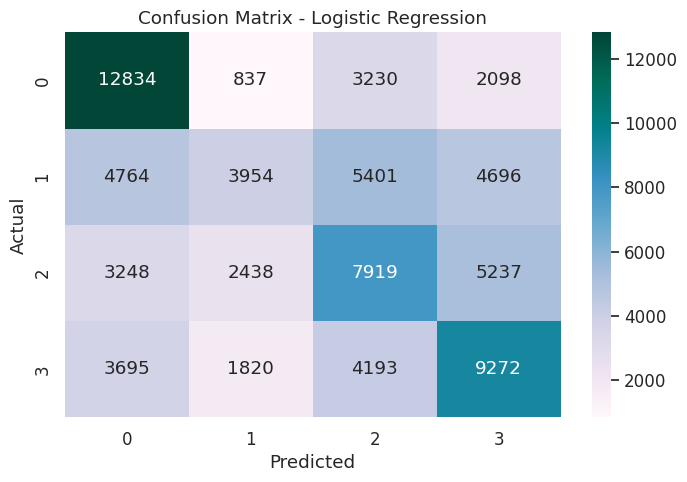

In [192]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(confmat, annot=True, fmt="d", cmap="PuBuGn")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


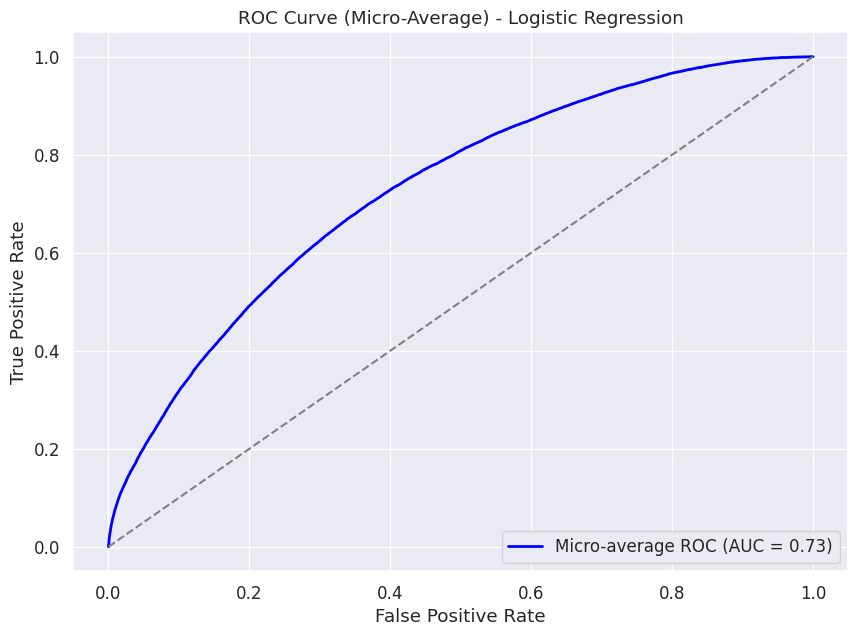

In [187]:
# ROC Curve - Micro-Average
Y_validate_binarized = label_binarize(y_validate, classes=[1, 2, 3, 4])
y_score = best_lr.predict_proba(X_validate)

# Micro-average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(Y_validate_binarized.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_micro, tpr_micro, color='blue', lw=2, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference

plt.title("ROC Curve (Micro-Average) - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

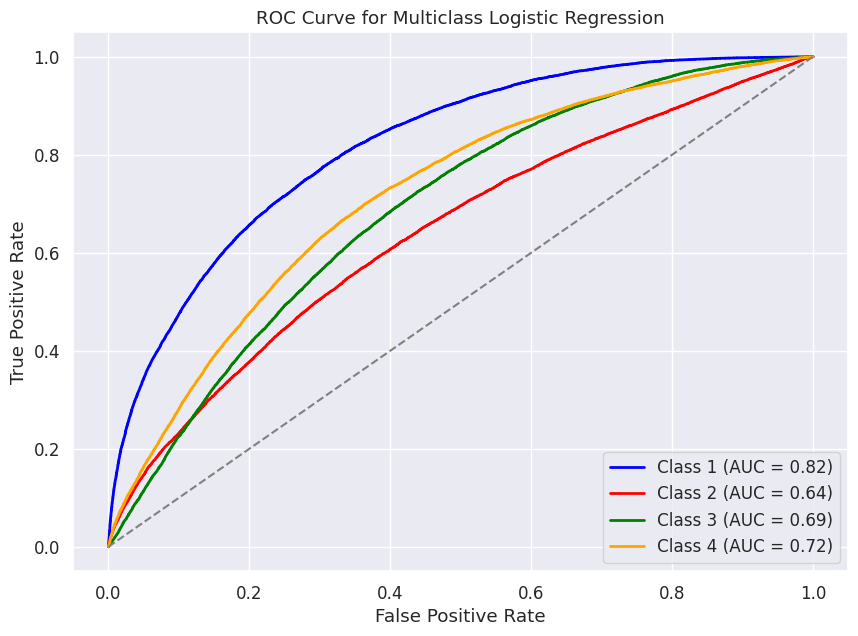

In [188]:
# ROC and PR Curve for Multiclass
Y_test_binarized = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = best_log_reg.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(Y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Logistic Regression")
plt.legend(loc="lower right")
plt.show()


In [193]:
print(severity_counts)

Severity
2    5098812
3    1282590
4     178324
1      63030
Name: count, dtype: int64
